# Anomaly Detection

> In this example we'll see how to detect anomalies for time series using insample prediction intervals.

::: {.callout-warning collapse="true"}

## Prerequesites

This tutorial assumes basic familiarity with StatsForecast. For a minimal example visit the [Quick Start](https://nixtla.github.io/statsforecast/examples/getting_started_short.html) 
:::

## Introduction 

Anomalies are unusual observations that don't follow the expected dataset patterns. When generating a forecast, it is important to identify them since they can lead to inconsistencies or erroneous results.

In this notebook, we'll show you how to detect anomalies in time series using the insample prediction intervals generated by [StatsForecast](https://nixtla.github.io/statsforecast/). 


**Outline:**

1. Install libraries 
2. Load and explore data 
3. Train the model 
4. Recover insample forecasts 
5. Identify and plot anomalies

::: {.callout-important}

## Important 

Once an anomaly has been identified, we need to decide what to do with it. For example, we could remove it or replace it with another value. The right course of action usually depends on the context of the problem, and is beyond the scope of this notebook. 
:::

:::{.callout-tip}
You can use Colab to run this Notebook interactively <a href="https://colab.research.google.com/github/Nixtla/statsforecast/blob/main/nbs/examples/AnomalyDetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>
:::

## Install libraries 

We assume that you have StatsForecast already installed. If not, check this guide for instructions on [how to install StatsForecast](https://nixtla.github.io/statsforecast/examples/installation.html) 

Install the necessary packages using `pip install statsforecast`

In [ ]:
pip install statsforecast

In [ ]:
import random
import warnings
warnings.filterwarnings("ignore")
from itertools import product

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from statsforecast import StatsForecast
from statsforecast.models import AutoARIMA

### Useful functions 

In [ ]:
def plot_grid(df_train, df_test=None, plot_random=True, level=None, anomalies=False):
    
    """Plot the insample prediction intervals and identify anomalies"""
    
    fig, axes = plt.subplots(4, 2, figsize = (24, 14))

    unique_ids = df_train['unique_id'].unique()

    assert len(unique_ids) >= 8, "Must provide at least 8 ts"
    
    if plot_random:
        unique_ids = random.sample(list(unique_ids), k=8)
    else:
        unique_uids = unique_ids[:8]

    for uid, (idx, idy) in zip(unique_ids, product(range(4), range(2))):
        train_uid = df_train.query('unique_id == @uid')
        axes[idx, idy].plot(train_uid['ds'], train_uid['y'], label = 'y_train')
        if level is not None and anomalies: 
            axes[idx, idy].fill_between(
                train_uid['ds'], 
                train_uid[f'AutoARIMA-lo-{level}'], 
                train_uid[f'AutoARIMA-hi-{level}'],
                alpha=0.9,
                color='orange',
                label=f'AutoARIMA_level_{level}',
            )
            filt = (train_uid['y'] > train_uid[f'AutoARIMA-hi-{level}']) | (train_uid[f'AutoARIMA-lo-{level}'] > train_uid['y'])
            anomalies_df = train_uid[filt][['ds', 'y']]
            axes[idx, idy].scatter(
                anomalies_df['ds'],
                anomalies_df['y'],
                color='red',
                label='Anomalies'
            )
        if df_test is not None:
            max_ds = train_uid['ds'].max()
            test_uid = df_test.query('unique_id == @uid')
            models = df_test.drop(['unique_id', 'ds'], axis=1).columns
            for model in models:
                if all(np.isnan(test_uid[model])):
                    continue
                if 'lo' in model or 'hi' in model:
                    continue
                axes[idx, idy].plot(test_uid['ds'], test_uid[model], label=model)
            if level is not None:
                for l in level:
                    axes[idx, idy].fill_between(
                        test_uid['ds'], 
                        test_uid[f'AutoARIMA-lo-{l}'], 
                        test_uid[f'AutoARIMA-hi-{l}'],
                        alpha=1 - l // 100,
                        color='orange',
                        label=f'AutoARIMA_level_{l}',
                    )
        axes[idx, idy].set_title(f'M4 Hourly: {uid}')
        axes[idx, idy].set_xlabel('Timestamp [t]')
        axes[idx, idy].set_ylabel('Target')
        axes[idx, idy].legend(loc='upper left')
        axes[idx, idy].xaxis.set_major_locator(plt.MaxNLocator(20))
        axes[idx, idy].grid()
    fig.subplots_adjust(hspace=0.5)
    plt.show()

## Load and explore the data 

The input to StatsForecast is always a data frame in [long format](https://www.theanalysisfactor.com/wide-and-long-data/) with three columns: `unique_id`, `ds` and `y`:

* The `unique_id` (string, int or category) represents an identifier for the series. 

* The `ds` (datestamp or int) column should be either an integer indexing time or a datestamp ideally like YYYY-MM-DD for a date or YYYY-MM-DD HH:MM:SS for a timestamp.

* The `y` (numeric) represents the measurement we wish to forecast. 

In this notebook, we'll use the Hourly dataset of the [M4 Competition](https://www.sciencedirect.com/science/article/pii/S0169207019301128). The data already has the required format described above, so no changes are needed. 

In [ ]:
%%capture
!wget https://auto-arima-results.s3.amazonaws.com/M4-Hourly.csv

In [ ]:
train = pd.read_csv('M4-Hourly.csv')

train.head()

unique_id  ds      y
0        H1   1  605.0
1        H1   2  586.0
2        H1   3  586.0
3        H1   4  559.0
4        H1   5  511.0

To reduce the total computational time, we'll only use a subset of the data. 

In [ ]:
n_series = 8
uids = train['unique_id'].unique()[:n_series]
train = train.query('unique_id in @uids')

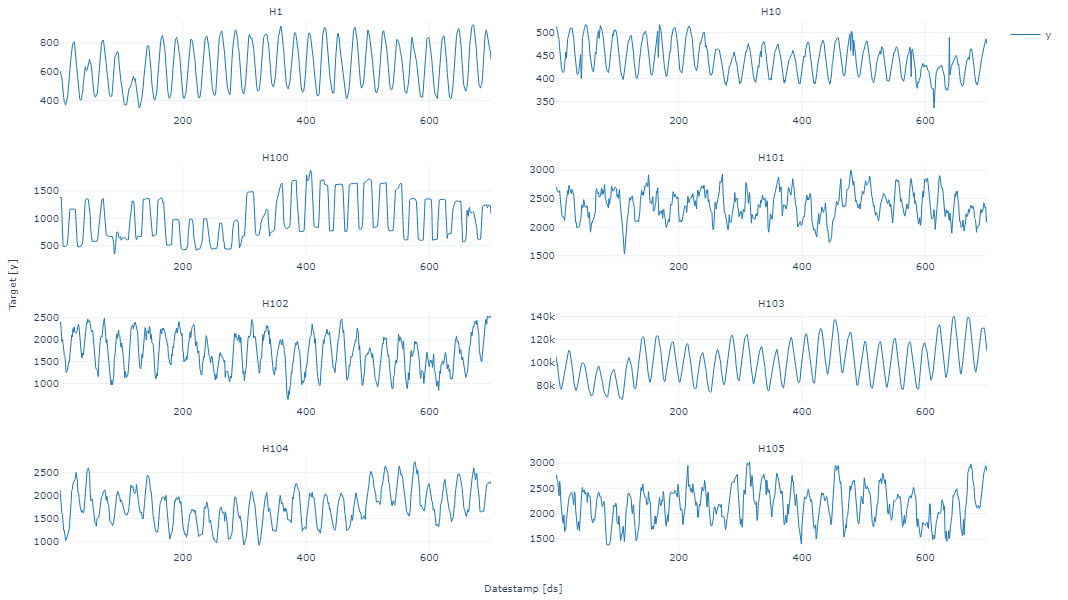

In [ ]:
StatsForecast.plot(train, plot_random=False)

## Train the model



For this example, we'll use `StatsForecast` [AutoARIMA](https://nixtla.github.io/statsforecast/models.html#autoarima). We'll need to: 

1. Create a list with the model. 
2. Instantiate a new `StatsForecast` object. 
3. Select the confidence levels for the prediction intervals. 
4. Generate the forecast using the `StatsForecast.forecast` method. 

In [ ]:
models = [AutoARIMA
        (season_length=24,   # Seasonalities of the time series. 24 for hourly data
        approximation=True)]

In [ ]:
fcst = StatsForecast(df=train, 
                     models=models, 
                     freq='H', 
                     n_jobs=-1)

In [ ]:
levels = [80, 90, 95, 99]

In [ ]:
forecasts = fcst.forecast(h=48, fitted=True, level=levels)

::: {.callout-note}
Observe that we need to pass `fitted=True` to the `forecast` method to recover the insample forecasts.
:::

For efficiency's sake, the forecast method converts the `unique_id` column to an index. You can revert to the default index of the data frame using the [pd.reset_index](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.reset_index.html) method from Pandas.

In [ ]:
forecasts = forecasts.reset_index()
forecasts.head()

unique_id   ds   AutoARIMA  AutoARIMA-lo-99  AutoARIMA-lo-95  \
0        H1  701  616.084167       585.106445       592.513000   
1        H1  702  544.432129       494.394348       506.358063   
2        H1  703  510.414490       443.625366       459.594238   
3        H1  704  481.046539       404.228729       422.595398   
4        H1  705  460.893066       378.863678       398.476410   

   AutoARIMA-lo-90  AutoARIMA-lo-80  AutoARIMA-hi-80  AutoARIMA-hi-90  \
0       596.302612       600.671814       631.496460       635.865662   
1       512.479370       519.536865       569.327393       576.384888   
2       467.764801       477.184906       543.644043       553.064148   
3       431.992798       442.827393       519.265686       530.100281   
4       408.511383       420.081024       501.705109       513.274780   

   AutoARIMA-hi-95  AutoARIMA-hi-99  
0       639.655273       647.061890  
1       582.506165       594.469910  
2       561.234741       577.203613  
3       539.497681       557.864380  
4       523.309692       542.922424

You can plot the forecast by calling the `StatsForecast.plot` method and passing in your forecast dataframe.

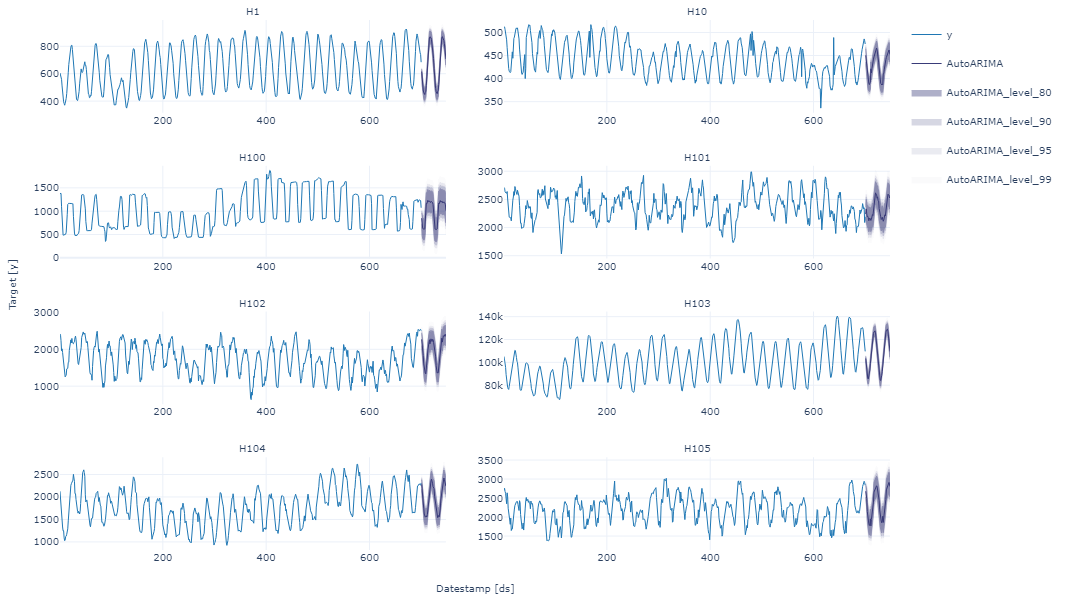

In [ ]:
StatsForecast.plot(train, forecasts, plot_random=False, level=levels) 

## Recover insample forecasts

Once the model is fitted, we can recover the insample forecasts and their prediction intervals using `forecast_fitted_values`.

In [ ]:
insample_forecasts = fcst.forecast_fitted_values().reset_index()
insample_forecasts.head()

unique_id  ds      y   AutoARIMA  AutoARIMA-lo-99  AutoARIMA-lo-95  \
0        H1   1  605.0  604.395020       573.417297       580.823853   
1        H1   2  586.0  585.414001       554.436279       561.842896   
2        H1   3  586.0  585.414001       554.436279       561.842896   
3        H1   4  559.0  558.441040       527.463318       534.869873   
4        H1   5  511.0  510.489014       479.511292       486.917877   

   AutoARIMA-lo-90  AutoARIMA-lo-80  AutoARIMA-hi-80  AutoARIMA-hi-90  \
0       584.613464       588.982666       619.807312       624.176514   
1       565.632507       570.001648       600.826355       605.195557   
2       565.632507       570.001709       600.826355       605.195557   
3       538.659485       543.028687       573.853333       578.222534   
4       490.707520       495.076691       525.901367       530.270569   

   AutoARIMA-hi-95  AutoARIMA-hi-99  
0       627.966125       635.372742  
1       608.985168       616.391724  
2       608.985168       616.391724  
3       582.012146       589.418762  
4       534.060181       541.466736

## Identify and plot anomalies

Here we'll consider as an **anomaly** any observation that is above or below the insample prediction intervals of a certain confidence level. Below we selected and plotted the 99% insample prediction intervals. All the observations that are classified as anomalies with this method are represented by a red dot. 

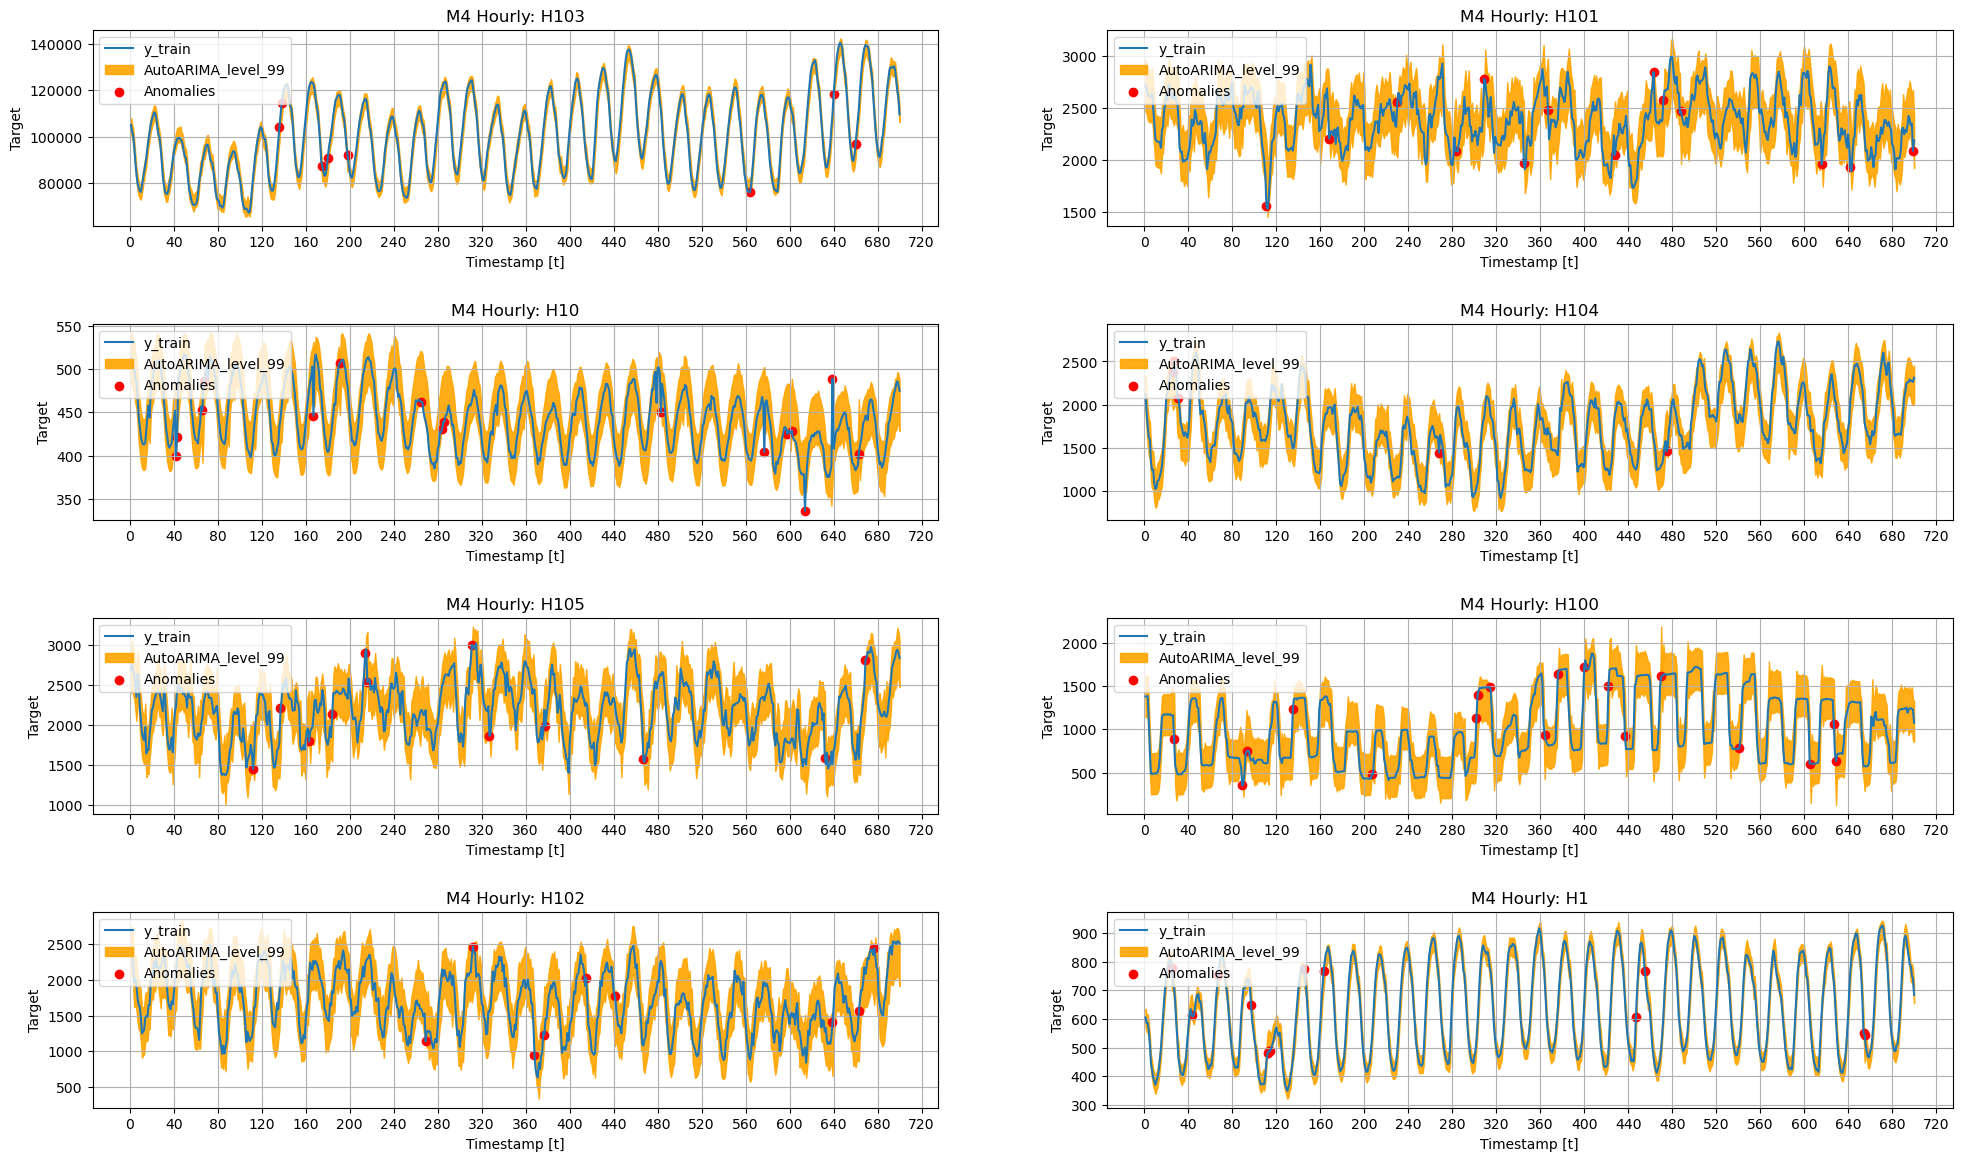

In [ ]:
plot_grid(insample_forecasts, level=99, anomalies=True)

The following code allows you to inspect the anomalies in detail.

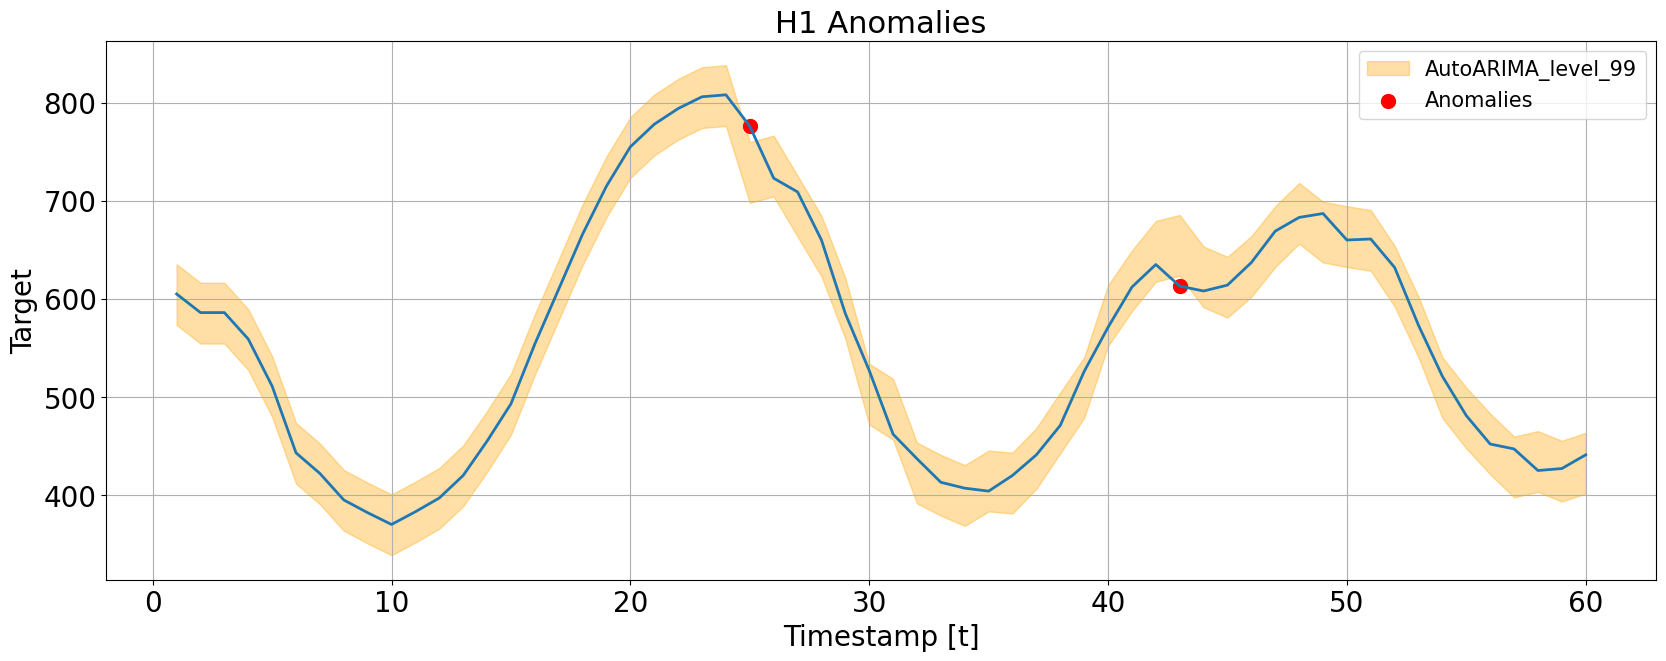

In [ ]:
uid = "H1"
fig, ax = plt.subplots(1, 1, figsize = (20, 7))
df_plot = insample_forecasts.query('unique_id == @uid')[:60]
ax.plot(df_plot['ds'], df_plot['y'], linewidth=2)
ax.fill_between(df_plot['ds'], 
                df_plot['AutoARIMA-lo-99'], 
                df_plot['AutoARIMA-hi-99'],
                alpha=.35,
                color='orange',
                label='AutoARIMA_level_99')
anomalies_df = df_plot.query('y > `AutoARIMA-hi-99` or y < `AutoARIMA-lo-99`')[['ds', 'y']]
ax.scatter(
    anomalies_df['ds'],
    anomalies_df['y'],
    color='red',
    label='Anomalies',
    s=100
)
ax.set_title(f'{uid} Anomalies', fontsize=22)
ax.set_ylabel('Target', fontsize=20)
ax.set_xlabel('Timestamp [t]', fontsize=20)
ax.legend(prop={'size': 15})
ax.grid()
for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontsize(20)